In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import cv2
from skimage import measure, filters, draw
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import tqdm 
from scipy import stats

import SimpleITK as sitk
import itkwidgets 
import napari
import copy
import gzip
import time

from napari.utils.colormaps import colormap_utils as cu

c:\Users\zoeba\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def find_slice_with_mask(mask):
    '''
    Détecte sur les index des premières et dernière tranches d'un masque. 
    Args:
        mask (np array): le masque ou le fond est des 1 et le masque des 0
    Return:
        (rangemin,rangemax) (int,int): tuple avec l'index des premières et dernière tranches d'un masque. 
    '''
    nb_slices_with_masks=[]
    for nb_slice in range(mask.shape[0]-1, 0,-1):
        if 255 in mask[nb_slice]:
            nb_slices_with_masks.append(nb_slice)
    rangemin = np.min(nb_slices_with_masks) #mask 1
    rangemax = np.max(nb_slices_with_masks) #mask 1
    return (rangemin,rangemax)

In [3]:
def fit_ellipses(mask, rangemin, rangemax):
    ''' 
    Le but est de récuperer les paramètres d'une liste ellipse en fonction d'une liste de masques fournis par le network construction
    Args :
        mask (numpy array) : masque des artères
        rangemin (int): début des coupes sélectionnées
        rangemax (int): fin des coupes sélectionnées
    Return:
        list_params_ellipses_to_return (list[list[double]]): paramètres de chaque ellipse
    '''
    list_params_ellipses=[]
    for index_img in (reversed(range(rangemax-rangemin))):
        img=mask[rangemin+index_img]
        contours_found,_=cv2.findContours(img.astype(np.uint8), method=cv2.RETR_LIST, mode=cv2.CHAIN_APPROX_SIMPLE)
        if len(contours_found)>0: 
            if len(contours_found[0])>5:
                ellipse=cv2.fitEllipse(contours_found[0])
                ellipse_ok=((ellipse[0][0], ellipse[0][1]), (ellipse[1][0]/2,ellipse[1][1]/2), ellipse[2])
                list_params_ellipses.append(ellipse_ok)
            else:
                ellipse_ok=((list_params_ellipses[-1][0][0], list_params_ellipses[-1][0][1]), (list_params_ellipses[-1][1][0]/2,ellipse[1][1]/2), list_params_ellipses[-1][2])
                list_params_ellipses.append(ellipse_ok)
        else:
            print("erreur nb contours")
            
    list_params_ellipses.reverse()
    return list_params_ellipses

In [4]:
def predict_and_compare_values(list_params, rangemin, rangemax, all_ranges_max):
    '''
    Ajuste les paramêtre des ellispes les unes par rapport au autres. 
    Args:
        list_params (list): les paramêtres originaux des ellipses pour un mask donné
        rangemin (int) : l'index de la première tranche de ce mask
        all_ranges_max (list[int]): les index maximums de chaque mask
    Return:
        new_list_params (list): les paramêtres des ellipses après modification pour un mask donné 
    '''
    
    new_list_params=[list_params[-1]]
    list_products_ab = [my_tuple[1][0]*my_tuple[1][1] for my_tuple in list_params]
    list_indexes= [ i for i in range(len(list_products_ab))]
    fit = np.polyfit(list_indexes, list_products_ab, deg=1)
    predict_size_area = np.poly1d(fit)
    list_products_ab_predicted=[predict_size_area(index) for index in list_indexes]
    
    # list_products_ab_predicted=[]
    # ranges_poly_fit=[rangemin]
    
    # for one_range in all_ranges_max:
    #     if one_range < rangemax-1 and one_range > rangemin:
    #         ranges_poly_fit.append(one_range)
    # ranges_poly_fit.append(rangemax)
    # ranges_poly_fit.sort()
    # print("ranges polyfit", ranges_poly_fit)

    # for index in range(len(ranges_poly_fit)-1):
    #     index_low=ranges_poly_fit[index]-rangemin
    #     index_high=ranges_poly_fit[index+1]-rangemin
    #     list_products_ab_per_segment=list_products_ab[index_low:index_high]
    #     list_indexes_per_segment= [ i for i in range(len(list_products_ab_per_segment))]
    #     print("list_products_ab_per_segment",list_products_ab_per_segment)
    #     print("list_indexes_per_segment",list_indexes_per_segment )
    #     fit = np.polyfit(list_indexes_per_segment, list_products_ab_per_segment, deg=1)
    #     predict_size_area = np.poly1d(fit)
    #     list_products_ab_predicted_per_segment=[predict_size_area(index_fit) for index_fit in list_indexes_per_segment]
    #     list_products_ab_predicted=list_products_ab_predicted+list_products_ab_predicted_per_segment

    count=0
    for index in reversed(range(len(list_products_ab_predicted)-1)):
        product_predicted=list_products_ab_predicted[index]
        if np.abs((product_predicted-list_products_ab[index])*100/product_predicted)<80: #si moins de 10 pourcent d'erreurs, je garde ma value originales
            new_list_params.append(list_params[index])
        elif (index+rangemin) in all_ranges_max:#si je suis à une jonction de 2 mask = bifurcation
            new_list_params.append(list_params[index])
        else: #sinon, je mets les param de l'ellipse précédente
            new_list_params.append(new_list_params[-1])
            count+=1
    new_list_params.reverse()
    return new_list_params, list_products_ab, list_products_ab_predicted

In [5]:
def dilation(img_3D, kernel_size):
    ''' 
    Dilatation d'une image 
    Args:
        img_3D (numpy array): image à dilater
        kernel_size (int): taille du kernel
    '''
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_size,kernel_size))
    for index, slice in enumerate(img_3D):
        img_3D[index] = cv2.dilate(img_3D[index] , kernel, iterations=1)

In [6]:
def create_3d_ellipses(list_params_ellipses, shape_image, rangemin, rangemax, dilate=False):
    ''' 
    Draw 3d ellipses on a white image
    Args:
        list_params_ellipses (list[list[double]]): the parameters of each ellipse
        mask (numpy array): the initial masks
        rangemin (int): first slice of the mask
        rangemax (int): last slice of the mask
        dilate (Boolean): indicatinf if neede to dliate of not the image
    Return:
        ellipses_3d (numpy array): images with drawing of ellipses on it
    '''
    ellipses_3d = []
    for index_img in (range(rangemax-rangemin)):
        ellipse_mask = np.zeros((shape_image[1],shape_image[2]), dtype=np.uint8)
        params = list_params_ellipses[index_img]
        center = (int(params[0][0]),int(params[0][1]))
        axis = (int(params[1][0]),int(params[1][1]))
        angle = int(params[2])
        color = 255
        cv2.ellipse(ellipse_mask, center, axis, angle, 0, 360, color,-1)
        ellipses_3d.append(ellipse_mask)
    numpy_ellipse_3d=np.array(ellipses_3d)
    if dilate:
        dilation(numpy_ellipse_3d, kernel_size=4)
    return numpy_ellipse_3d

In [7]:
def keeping_arteries_only(filled_ellipses, image):
    '''
    Le but est de garder l'image originale en la restreignant à l'intérieur des ellipses.
    Args:
        filled_ellipses (np.array): les ellipses remplies
        image (np.array): image d'origine 
    Return:
        list_arteries_only (np.array): l'image originale restreinte à l'intérieur des ellipses
    ''' 
    list_arteries_only=np.where(filled_ellipses==255, image, 0)
    return list_arteries_only

In [8]:
def construct_ellipses_network(mask, rangemin,rangemax, all_ranges_max): 
    '''
    En partant de la liste de masques construite par la network construction, des ellipses sont approximées pour reconstruire un réseau artériel lisse. 
    Args:
        mask_list (list[np.array]): la liste des masque construite par la network construction
        rangemin (int): last slice of the mask in the total 3D block
        rangemax (int): first slice of the mask in the total 3D block
        all_ranges_max (list[int]): les index maximums de chaque mask

    Return:
        info_all_masks (list[dic]): une liste où pour chaque loigne (qui correspond à un masque), il y a un dictionnaire où les clefs sont: rangemin, rangemax, mask,  smooth_ellipses
    ''' 
    list_params=fit_ellipses(mask, rangemin, rangemax)
       
    new_list_param, list_products_ab, list_products_ab_predicted=predict_and_compare_values(list_params, rangemin,rangemax, all_ranges_max)
    new_ellipses_3d=create_3d_ellipses(new_list_param,mask.shape, rangemin, rangemax, dilate=True)

    before=np.zeros((rangemin, mask.shape[1],mask.shape[1]))
    after=np.zeros((mask.shape[0]-rangemax, mask.shape[1],mask.shape[1]))
    whole_size_ellipses_3D=np.concatenate((before,new_ellipses_3d,after))

    info_of_one_mask={'rangemin':rangemin,
                      'rangemax':rangemax,
                      'mask':mask, 
                      'ellipses_3D':whole_size_ellipses_3D, 
                      'list_ab':list_products_ab,
                      'list_ab_predicted':list_products_ab_predicted
                      }
    return info_of_one_mask

In [9]:
def construct_mask_network(mask_list,min_range,max_range):
    '''
    En partant de la liste de masques, le réseau complet est construit. 
    Args:
        mask_list (list[np.array]): la liste des masque construite par la network construction
        min_range (int): l'index du premier masque à traiter
        max_range (int): l'index du dernier masque à traiter

    Return:
        mask_network (np.array): l'image 3D où le réseau de mask est reconstitué
    ''' 
    mask_network=np.zeros(mask_list[0].shape)
    print("Constructing the mask network...", end= " ")
    for index_mask in (range(min_range, max_range)):
        mask_network=np.where(mask_list[index_mask]!=0,mask_list[index_mask],mask_network)  
    print("Done")
    return mask_network

Stats

In [16]:
class Descriptor:
    def __init__(self, index, list_pixels, ab, ab_pred):
        self.index = index
        self.list_pixels = list_pixels
        self.list_pixels_without_calcifications = self.remove_calcifications(list_pixels)
        self.mean = self.compute_mean()
        self.sd = self.compute_sd()
        self.proportion_calcification = self.compute_calcification()
        self.value_occlusion = []
        self.ab = ab
        self.ab_pred = ab_pred

        self.deviation_mean = -1
        self.deviation_sd = -1
        # self.ellipse_original_too_big = self.compare_ab_ab_pred()

    def get_index(self):
        return  self.index

    def get_list_pixels(self):
        return  self.list_pixels

    def get_list_pixels_without_calcifications(self):
        return  self.list_pixels_without_calcifications
     
    def get_mean(self):
        return self.mean
    
    def get_sd(self):
        return self.sd

    def get_proportion_calcification(self):
        return self.proportion_calcification
    
    def get_value_occlusion(self):
        return self.value_occlusion
    
    def get_ab(self):
        return self.ab

    def get_ab_pred(self):
        return self.ab_pred
    
    def get_deviation_mean(self):
        return self.deviation_mean
    
    def get_deviation_sd(self):
        return self.deviation_sd
    
    # def get_ellipse_original_too_big(self):
    #     return self.ellipse_original_too_big

    def remove_calcifications(self, list_pixels):
        list_without_calcifications = [valeur for valeur in list_pixels if valeur < 250]
        return list_without_calcifications

    def compute_mean(self):
        return np.mean(self.list_pixels_without_calcifications)

    def compute_sd(self):
        return np.std(self.list_pixels_without_calcifications)
    
    def compute_deviation_mean(self, mean_mean_slice_mask):
        self.deviation_mean = ((self.mean-mean_mean_slice_mask)/mean_mean_slice_mask)*100
    
    def compute_deviation_sd(self, mean_sd_slice_mask):
        self.deviation_sd = ((self.sd-mean_sd_slice_mask)/mean_sd_slice_mask)*100

    # def compare_ab_ab_pred(self):
    #     if ((self.ab - self.ab_pred)/self.ab_pred)*100 > 80:
    #         return True
    #     else:
    #         return False
            
    def compute_calcification(self):
        nb_pixel_250 = sum(1 for valeur in self.list_pixels if valeur > 250)
        proportion = nb_pixel_250 / len(self.list_pixels)
        return proportion

    def compute_occlusion(self, list_reference):
        stat_value = stats.ks_2samp(self.list_pixels_without_calcifications, list_reference)
        self.value_occlusion = stat_value[0]

In [11]:
def compute_stats(info_one_mask, arteries):  
      
    rangemin=info_one_mask['rangemin']
    rangemax=info_one_mask['rangemax']
    arteries=arteries[rangemin:rangemax]
    ellipses3D=info_one_mask['ellipses_3D'][rangemin:rangemax]
    list_ab=info_one_mask['list_ab']
    list_ab_predicted=info_one_mask['list_ab_predicted']

    list_descriptor = []
    #Récupérer une liste de valeurs de pixels par slice, en prenant en compte uniquement les pixels dans l'ellipse
    arteries_only = np.where(ellipses3D == 255, arteries, np.nan)

    # créer l'objet descriptor pour chaque slice
    for index, slice in enumerate(arteries_only):
        slice = slice.flatten()
        slice = list(slice[np.logical_not(np.isnan(slice))]) # remove nan
        list_descriptor.append(Descriptor(index+rangemin, slice,list_ab[index], list_ab_predicted[index]))

    list_reference = []
    list_mean_descriptors=[]
    list_sd_descriptors=[]
    for descriptor in list_descriptor:
        list_reference = np.concatenate((list_reference, descriptor.get_list_pixels_without_calcifications()))
        list_mean_descriptors.append(descriptor.get_mean())
        list_sd_descriptors.append(descriptor.get_sd())

    for descriptor in list_descriptor:
        descriptor.compute_deviation_mean(np.mean(list_mean_descriptors))
        descriptor.compute_deviation_sd(np.mean(list_sd_descriptors))
        descriptor.compute_occlusion(list_reference)

    return list_descriptor

In [12]:
def convert_stats_to_table(list_descriptor):
    #créer un tableau regroupant les caractéristiques des objets
    tableau_attributs = [
        [objet.get_index(), 
         objet.get_mean(), 
         objet.get_deviation_mean(), 
         objet.get_sd(), 
         objet.get_deviation_sd(), 
         objet.get_proportion_calcification(), 
         objet.get_value_occlusion(), 
         objet.get_ab(), 
         objet.get_ab_pred()] for objet in list_descriptor
    ]

    df = pd.DataFrame(tableau_attributs, columns=['index', 'mean', 'deviation_mean', 'sd', 'deviation_sd', 'proportion_calcification', 'value_occlusion', 'ab', 'ab_pred'])
    return df

In [13]:
def constructing_all_networks(image_preprocessed, mask_list, min_range, max_range, reconstruct_ellipse=False, reconstruct_arteries=False, reconstruct_masks=False):
    '''
    Fonction qui permet de construire les réseaux d'artères, d'ellipses et de masks. 
    Args:
        image_preprocessed (np.array): l'image pré-traitée
        mask_list (list[np.array]): la liste des masque construite par la network construction
        min_range (int): l'index du premier masque à traiter
        max_range (int): l'index du dernier masque à traiter
        reconstruct_ellipse (boolean): indique si le réseau d'ellipses doit être construit
        reconstruct_arteries (boolean): indique si le réseau d'artères doit être construit
        reconstruct_masks (boolean): indique si le réseau de masks doit être construit

    Return:
        mask_network (np.array): l'image 3D où le réseau de mask est reconstitué
        ellipses_network (np.array): l'image 3D où le réseau d'ellipses est reconstitué
        arteries_network (np.array): l'image 3D où le réseau d'artères est reconstitué
    ''' 
    ellipses_network=np.zeros_like(mask_list[0])
    arteries_network=np.zeros_like(mask_list[0])
    mask_network=np.zeros_like(mask_list[0])

    list_table_stats=[]

    all_ranges_max=[] #storing all index where there is a bifurcation
    for index in range(len(mask_list)): #attention ici remettre len(mask_list)
        print(index)
        all_ranges_max.append(find_slice_with_mask(mask_list[index])[1])

    if (max_range-min_range)==1:
        print(1, " out of ", 1)
        rangemin,rangemax=find_slice_with_mask(mask_list[min_range])
        info_one_mask= construct_ellipses_network(mask_list[min_range],rangemin,rangemax+1, all_ranges_max)
        ellipses_network=info_one_mask['ellipses_3D']
        arteries_network=keeping_arteries_only(info_one_mask['ellipses_3D'], image_preprocessed)
        mask_network=mask_list[min_range]
        
        # list_descriptor=compute_stats(arteries_network[rangemin:rangemax+1], ellipses_network[rangemin:rangemax+1], rangemin)
        list_descriptor=compute_stats(info_one_mask, arteries_network)
        df=convert_stats_to_table(list_descriptor)
        list_table_stats.append(df)
    else:
        for index in tqdm.tqdm(range(min_range,max_range)):
            rangemin,rangemax=find_slice_with_mask(mask_list[index])
            info_one_mask= construct_ellipses_network(mask_list[index],rangemin,rangemax+1, all_ranges_max)
    
            if reconstruct_ellipse:
                ellipses_network=np.where(info_one_mask['ellipses_3D']!=0, info_one_mask['ellipses_3D'], ellipses_network)
            arteries=keeping_arteries_only(info_one_mask['ellipses_3D'], image_preprocessed)
            if reconstruct_arteries:
                arteries_network=np.where(arteries!=0,arteries, arteries_network)
                
            list_descriptor=compute_stats(info_one_mask, arteries)
            df=convert_stats_to_table(list_descriptor)
            list_table_stats.append(df) 
            
        if reconstruct_masks :
            mask_network=construct_mask_network(mask_list,min_range,max_range)
    return mask_network, ellipses_network, arteries_network, list_table_stats

In [14]:
f = gzip.GzipFile('temp/mask_list.npy.gz', "r")
mask_list = np.load(f)
print(mask_list.shape)
image_preprocessed = np.load(Path("temp/preprocessed_image.npy"))

(15, 1532, 512, 512)


# attention à mettre False en argument de la fonction

In [20]:
minrange=3
maxrange=4#len(mask_list)
mask_network, ellipses_network, arteries_network, list_table_stats=constructing_all_networks(
    image_preprocessed, 
    mask_list, 
    min_range=minrange, 
    max_range=maxrange, 
    reconstruct_ellipse=True, 
    reconstruct_arteries=True, 
    reconstruct_masks=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1  out of  1


In [34]:
# viewer = napari.Viewer()
# image_layer = viewer.add_image(arteries_network, colormap="gray", contrast_limits=(0,255))
# image_layer = viewer.add_image(ellipses_network, colormap="blue", contrast_limits=(0,255), blending="additive")
# image_layer = viewer.add_image(mask_network, colormap="green", contrast_limits=(0,255), blending="additive")
# napari.run()

In [17]:
# image_original = sitk.ReadImage(Path("data/anonymise_patient1.mhd"))
# image_original_array = sitk.GetArrayViewFromImage(image_original)

In [18]:
# to_view=np.where(ellipses_network==255, arteries_network, image_original_array)

In [21]:
viewer = napari.Viewer()
image_layer = viewer.add_image(image_preprocessed, colormap="gray")
image_layer = viewer.add_image(ellipses_network, colormap="blue", contrast_limits=(0,255), blending="additive")
image_layer = viewer.add_image(mask_network, colormap="green", contrast_limits=(0,255), blending="additive")
napari.run()

In [54]:
viewer = napari.Viewer()
# image_layer = viewer.add_image(to_view, colormap="gray", contrast_limits=(0,255))
image_layer = viewer.add_image(image_preprocessed, colormap="gray", contrast_limits=(0,255))
# image_layer = viewer.add_image(ellipses_network,colormap="blue", blending="additive")
colorindex = 0
for mask in mask_list:
    if np.sum(mask) > 0:
        image_layer = viewer.add_image(mask,colormap=list(cu.AVAILABLE_COLORMAPS.keys())[colorindex%5],blending="additive")
        colorindex+=1
napari.run()

stats on output dataframe




In [21]:
# list_table_stats_all=pd.concat([i for i in list_table_stats])
# list_table_stats_all=list_table_stats_all.sort_values(by=['index'])

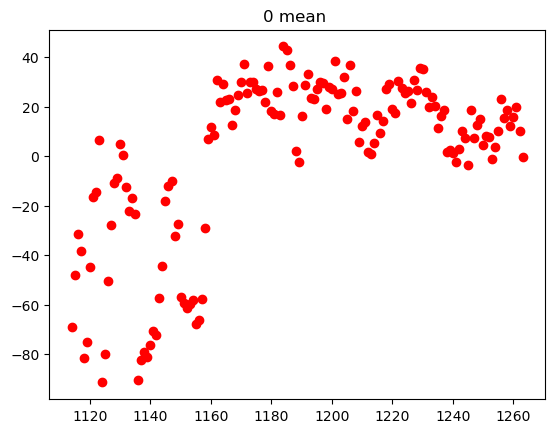

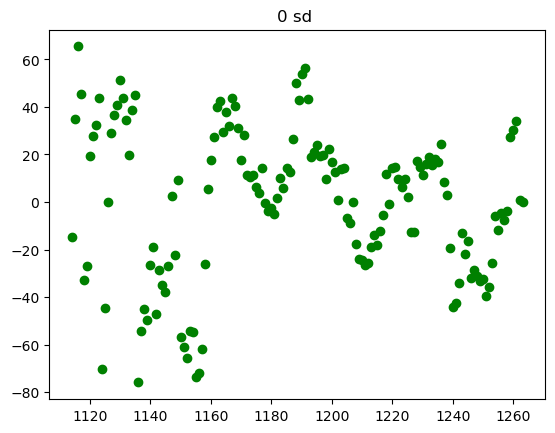

In [22]:
for indice_mask, tab in enumerate(list_table_stats):
    plt.scatter(tab['index'],tab['deviation_mean'], color="red")
    plt.title(str(indice_mask)+" mean ")
    plt.show()
    plt.scatter(tab['index'],tab['deviation_sd'], color="green")
    plt.title(str(indice_mask)+ " sd ")
    plt.show()